<a href="https://colab.research.google.com/github/M-Nadeem-AIML/Multivariat-TimeSeries-RNN-LSTM/blob/main/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
#sudo pip h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from sklearn.preprocessing import MinMaxScaler

notebookstart= time.time()

2022-07-25 23:44:43.145969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-25 23:44:43.146008: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

In [ ]:
#Load data
import openpyxl
df_data = pd.read_excel('dataset.xlsx',index_col = 'Date')
print("DataFrame Shape: {} rows, {} columns".format(*df_data.shape))
display(df_data.head())

DataFrame Shape: 60 rows, 7 columns


,Y,X2,X3,X4,X5,X6,X7
Date,,,,,,,
2019-01-01,674100.0,103.0,0.4,2158.0,2811.0,128.073107,6.11
2019-02-01,575800.0,103.0,0.4,2124.0,2633.0,127.182962,5.93
2019-03-01,666900.0,103.0,0.4,2713.0,3566.0,125.408625,5.88
2019-04-01,681010.0,103.0,0.4,2696.0,3489.0,124.049409,5.82
2019-05-01,764620.0,103.0,0.4,3059.0,3916.0,123.062657,5.76


In [ ]:
df=df_data.dropna()

In [ ]:
# Check for null values
print(df.isnull().any())

Y     False
X2    False
X3    False
X4    False
X5    False
X6    False
X7    False
dtype: bool


In [ ]:
#split data
train_size = int(len(df)*0.80)
test_size = len(df)-train_size

train,test = df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(len(train),len(test))

33 9


In [ ]:
# Feature Scaling
from sklearn.preprocessing import RobustScaler

F_col = ['X2', 'X3','X4','X5','X6','X7']

Rs = MinMaxScaler()
Rs_t = MinMaxScaler()

Rs = Rs.fit(train[F_col].to_numpy())
Rs_t = Rs_t.fit(train[['Y']])

train.loc[:,F_col] = Rs.transform(train[F_col].to_numpy())
train['Y'] = Rs_t.transform(train[['Y']])


test.loc[:,F_col] = Rs.transform(test[F_col].to_numpy())
test['Y'] = Rs_t.transform(test[['Y']])

/tmp/ipykernel_136049/2273857012.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,F_col] = Rs.transform(train[F_col].to_numpy())
/tmp/ipykernel_136049/2273857012.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Y'] = Rs_t.transform(train[['Y']])
/tmp/ipykernel_136049/2273857012.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,F_col] = Rs.

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [ ]:
time_steps = 3

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Y, time_steps)
X_test, y_test = create_dataset(test, test.Y, time_steps)

print(X_train.shape, y_test.shape)


(30, 3, 7) (6,)


In [ ]:
X_test.view()

array([[[ 0.66339774,  1.        ,  1.        ,  0.94596632,
          0.92686902,  0.63403062, -0.05102041],
        [ 1.04248633,  1.        ,  1.        ,  1.13772305,
          1.0926869 ,  0.63183191, -0.10204082],
        [ 0.83362978,  1.        ,  1.33333333,  1.10856999,
          1.0627419 ,  0.64671718, -0.13265306]],

       [[ 1.04248633,  1.        ,  1.        ,  1.13772305,
          1.0926869 ,  0.63183191, -0.10204082],
        [ 0.83362978,  1.        ,  1.33333333,  1.10856999,
          1.0627419 ,  0.64671718, -0.13265306],
        [ 0.59832282,  1.        ,  1.33333333,  0.89042473,
          0.81829293,  0.63534303, -0.18367347]],

       [[ 0.83362978,  1.        ,  1.33333333,  1.10856999,
          1.0627419 ,  0.64671718, -0.13265306],
        [ 0.59832282,  1.        ,  1.33333333,  0.89042473,
          0.81829293,  0.63534303, -0.18367347],
        [ 0.50527892,  1.        ,  1.33333333,  0.8964564 ,
          0.81381137,  0.58449572, -0.21428571]],

    

In [ ]:
model = keras.Sequential()
model.add(
    keras.layers.LSTM(
      units=32, 
      input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = False
    )
  )

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1,kernel_regularizer='l1'))
model.compile(loss='mean_squared_error', optimizer='SGD', metrics = ['mse'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
history = model.fit(
    X_train, y_train, 
    epochs=40, 
    batch_size=6,
    #steps_per_epoch = 12,
    callbacks = early_stopping,
    validation_split= 0.2,
    shuffle=False
)

Epoch 1/40
4/4 [==============================] - 1s 120ms/step - loss: 0.4759 - mse: 0.4114 - val_loss: 0.4598 - val_mse: 0.3956
Epoch 2/40
4/4 [==============================] - 0s 7ms/step - loss: 0.3449 - mse: 0.2808 - val_loss: 0.3466 - val_mse: 0.2827
Epoch 3/40
4/4 [==============================] - 0s 10ms/step - loss: 0.3074 - mse: 0.2435 - val_loss: 0.2608 - val_mse: 0.1972
Epoch 4/40
4/4 [==============================] - 0s 8ms/step - loss: 0.2227 - mse: 0.1592 - val_loss: 0.2071 - val_mse: 0.1437
Epoch 5/40
4/4 [==============================] - 0s 11ms/step - loss: 0.2018 - mse: 0.1384 - val_loss: 0.1673 - val_mse: 0.1040
Epoch 6/40
4/4 [==============================] - 0s 10ms/step - loss: 0.1779 - mse: 0.1146 - val_loss: 0.1401 - val_mse: 0.0770
Epoch 7/40
4/4 [==============================] - 0s 12ms/step - loss: 0.1363 - mse: 0.0731 - val_loss: 0.1227 - val_mse: 0.0596
Epoch 8/40
4/4 [==============================] - 0s 11ms/step - loss: 0.1387 - mse: 0.0757 - val_

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 32)                5120      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


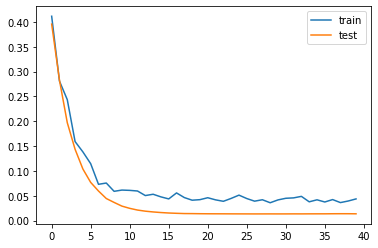

In [ ]:
# plot performance
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend();

In [ ]:
X_test.view()


array([[[ 0.66339774,  1.        ,  1.        ,  0.94596632,
          0.92686902,  0.63403062, -0.05102041],
        [ 1.04248633,  1.        ,  1.        ,  1.13772305,
          1.0926869 ,  0.63183191, -0.10204082],
        [ 0.83362978,  1.        ,  1.33333333,  1.10856999,
          1.0627419 ,  0.64671718, -0.13265306]],

       [[ 1.04248633,  1.        ,  1.        ,  1.13772305,
          1.0926869 ,  0.63183191, -0.10204082],
        [ 0.83362978,  1.        ,  1.33333333,  1.10856999,
          1.0627419 ,  0.64671718, -0.13265306],
        [ 0.59832282,  1.        ,  1.33333333,  0.89042473,
          0.81829293,  0.63534303, -0.18367347]],

       [[ 0.83362978,  1.        ,  1.33333333,  1.10856999,
          1.0627419 ,  0.64671718, -0.13265306],
        [ 0.59832282,  1.        ,  1.33333333,  0.89042473,
          0.81829293,  0.63534303, -0.18367347],
        [ 0.50527892,  1.        ,  1.33333333,  0.8964564 ,
          0.81381137,  0.58449572, -0.21428571]],

    

In [ ]:
y_pred = model.predict(X_test)
print(y_pred.shape)

(6, 1)


In [ ]:
y_train_inv = Rs_t.inverse_transform(y_train.reshape(1,-1))
y_test_inv = Rs_t.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = Rs_t.inverse_transform(y_pred)

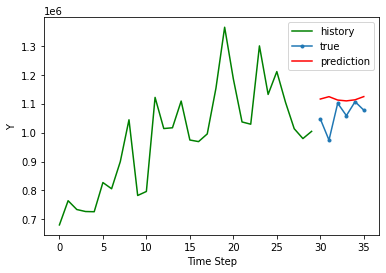

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Y')
plt.xlabel('Time Step')
plt.legend()
plt.show();

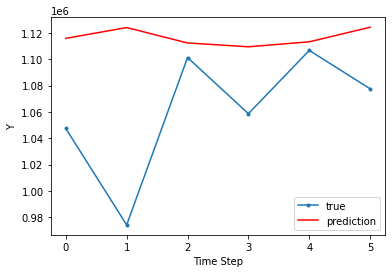

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Y')
plt.xlabel('Time Step')
plt.legend()
plt.show();

ADD second layer

In [ ]:
model2 = keras.models.Sequential()

model2.add(keras.layers.LSTM(units=32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model2.add(keras.layers.LSTM(128, activation = 'tanh',dropout = 0.3))
model2.add(keras.layers.Dense(units=1,kernel_regularizer='l1'))
model2.compile(loss='mean_squared_error', optimizer='SGD', metrics = ['mse'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
history2 = model2.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=4,
    #steps_per_epoch = 12,
    callbacks = early_stopping,
    validation_split= 0.2,
    shuffle=False
)

Epoch 1/50
6/6 [==============================] - 2s 120ms/step - loss: 0.3881 - mse: 0.2608 - val_loss: 0.4401 - val_mse: 0.3131
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 0.3197 - mse: 0.1930 - val_loss: 0.3600 - val_mse: 0.2336
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.2707 - mse: 0.1446 - val_loss: 0.3039 - val_mse: 0.1780
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 0.2397 - mse: 0.1141 - val_loss: 0.2641 - val_mse: 0.1388
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 0.2185 - mse: 0.0935 - val_loss: 0.2353 - val_mse: 0.1105
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 0.2052 - mse: 0.0807 - val_loss: 0.2142 - val_mse: 0.0899
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 0.1955 - mse: 0.0716 - val_loss: 0.1985 - val_mse: 0.0748
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 0.1877 - mse: 0.0644 - val_loss:

In [ ]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3, 32)             5120      
                                                                 
 lstm_17 (LSTM)              (None, 128)               82432     
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 87,681
Trainable params: 87,681
Non-trainable params: 0
_________________________________________________________________


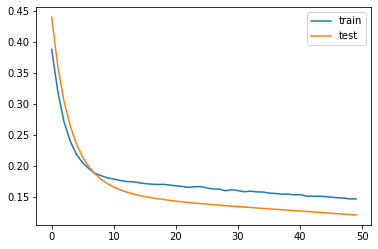

In [ ]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred2 = model2.predict(X_test)
print(y_pred.shape)

(6, 1)


In [ ]:
y_train_inv2 = Rs_t.inverse_transform(y_train.reshape(1,-1))
y_test_inv2 = Rs_t.inverse_transform(y_test.reshape(1,-1))
y_pred_inv2 = Rs_t.inverse_transform(y_pred2)

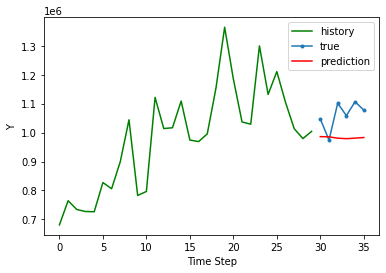

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv2.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv2.flatten(), 'r', label="prediction")
plt.ylabel('Y')
plt.xlabel('Time Step')
plt.legend()
plt.show();

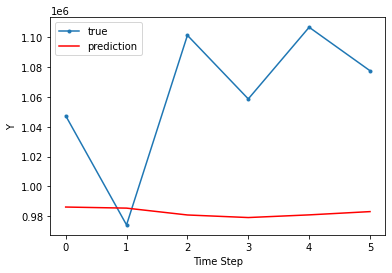

In [ ]:
plt.plot(y_test_inv2.flatten(), marker='.', label="true")
plt.plot(y_pred_inv2.flatten(), 'r', label="prediction")
plt.ylabel('Y')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = (np.mean(np.abs((actual-predictions)/actual))*100)
    mae = np.mean(errors)*100
    print(model_name + ':')
    
    #print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    #print('Mean squered Error:{:.4f}'.format(mse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
    print('Mean Percentage Error: {:.4f}'.format(mae))
    
evaluate_prediction(y_pred, y_test, 'LSTM 1 layer')

evaluate_prediction(y_pred2, y_test, 'LSTM 2 layer')

LSTM 1 layer:
Root Mean Square Error: 0.0905
Mean Absolute Percentage Error: 12.5040
Mean Percentage Error: 7.0610
LSTM 2 layer:
Root Mean Square Error: 0.1143
Mean Absolute Percentage Error: 16.1038
Mean Percentage Error: -9.9562
